# Predicting Dominant Household Spending Categories from Demographic Features

This notebook presents a structured data science project built around the following objective:

### Project Goal  
To predict the **dominant household spending category** — such as housing, food, or personal services — for a demographic group, using only high-level features: **income, region, and age group**.

---

### Key Question  
*Can we uncover predictable patterns in what households prioritize in their spending, based solely on simple demographic information?*

---

### Dataset   
We use a **Canadian public household expenditure survey**, which reports **average spending per category** across demographic groups — each defined by combinations of income bracket, age group, and geographic region.  



## 1. Setup and initial data exploration

We begin by importing required Python libraries, setting up our environment, and loading the dataset.

This section includes:
- Installing/importing necessary packages
- Loading the dataset
- Performing a quick inspection to understand its structure, types, and contents

In [5]:
# Load Libraries and Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import os


In [8]:
# Load the dataset
df = pd.read_csv("Income_expense_data.csv")

### Initial Data Inspection

In [9]:
print("Shape:", df.shape)
df.head()
df.info()
df.describe(include='all')

Shape: (13260, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13260 entries, 0 to 13259
Data columns (total 12 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   REF_DATE                                          13260 non-null  int64  
 1   GEO                                               13260 non-null  object 
 2   Statistic                                         13260 non-null  object 
 3   Before-tax household income quintile              13260 non-null  object 
 4   Household expenditures, summary-level categories  13260 non-null  object 
 5   UOM                                               13260 non-null  object 
 6   COORDINATE                                        13260 non-null  object 
 7   Expense                                           13024 non-null  float64
 8   Family type                                       13260 non-null  object 
 9 

,REF_DATE,GEO,Statistic,Before-tax household income quintile,"Household expenditures, summary-level categories",UOM,COORDINATE,Expense,Family type,Age of older adult,Family income,Income
count,13260.000000,13260,13260,13260,13260,13260,13260,13024.000000,13260,13260,13260,1.325400e+04
unique,NaN,13,1,6,17,1,1326,NaN,1,6,17,NaN
top,NaN,Province 1,Average expenditure per household,All quintiles,Total expenditure,Dollars,C1,NaN,Couple families,Total all ages,All income groups,NaN
freq,NaN,1020,13260,2210,780,13260,10,NaN,13260,2210,780,NaN
mean,2014.800000,NaN,NaN,NaN,NaN,NaN,NaN,9628.216063,NaN,NaN,NaN,1.900229e+05
std,3.340785,NaN,NaN,NaN,NaN,NaN,NaN,21039.898472,NaN,NaN,NaN,7.889770e+05
min,2010.000000,NaN,NaN,NaN,NaN,NaN,NaN,65.000000,NaN,NaN,NaN,2.000000e+01
25%,2012.000000,NaN,NaN,NaN,NaN,NaN,NaN,1552.000000,NaN,NaN,NaN,4.740000e+03
50%,2014.500000,NaN,NaN,NaN,NaN,NaN,NaN,3195.500000,NaN,NaN,NaN,1.547000e+04
75%,2017.000000,NaN,NaN,NaN,NaN,NaN,NaN,8434.500000,NaN,NaN,NaN,4.330000e+04


In [14]:
df.head()

,REF_DATE,GEO,Statistic,Before-tax household income quintile,"Household expenditures, summary-level categories",UOM,COORDINATE,Expense,Family type,Age of older adult,Family income,Income
0,2010,Province 1,Average expenditure per household,All quintiles,Total expenditure,Dollars,C1,72075.0,Couple families,Total all ages,All income groups,7989380.0
1,2010,Province 1,Average expenditure per household,All quintiles,Food purchased from stores,Dollars,C2,5709.0,Couple families,Total all ages,"Under $10,000",189700.0
2,2010,Province 1,Average expenditure per household,All quintiles,Food purchased from restaurants,Dollars,C3,2141.0,Couple families,Total all ages,"$10,000 and over",7799670.0
3,2010,Province 1,Average expenditure per household,All quintiles,Shelter,Dollars,C4,15020.0,Couple families,Total all ages,"$15,000 and over",7695970.0
4,2010,Province 1,Average expenditure per household,All quintiles,Principal accommodation,Dollars,C5,13586.0,Couple families,Total all ages,"$20,000 and over",7552050.0


## 2. Data Preprocessing

This dataset contains household expenditure data categorized by type (e.g., food, shelter, communications), across different demographic groups.

To prepare the data for modeling, we performed the following steps:

1. Filter to relevant data

    Kept only rows where Statistic == "Average expenditure per household" to focus on average behavior rather than totals or percentiles.

    Removed rows with missing or zero values for Income or Expense.

We want clean, reliable rows where the average household income and category-level spending are defined and non-zero — critical for identifying dominant spending priorities.

2. Drop general/aggregate labels

    Removed rows where Family income was "All income groups" or "Median total income"

    Removed rows where Age of older adult was "Total all ages"

These are aggregate rows rather than distinct groups — they would distort or dilute the signal we’re trying to learn.

3. Group fine-grained expenditure categories into broader “super categories”

Mapped the 15+ original expenditure categories into 5 meaningful macro-categories:

Original Categories	                   |     Grouped As

Food purchased (at home & restaurants)	  |  Food

Shelter, rent, utilities, housing expenses| Housing

Furnishings, equipment, appliances	      | Household Goods

Household services (e.g., cleaning help)	| Household Services

Clothing, communications, misc. personal	| Personal & Other

4. Construct the target variable

    For each unique demographic group (defined by GEO, Age of older adult, and Income), we selected the category with the highest average expense as the dominant spending category.

Rather than model raw expenditure values, we focus on what category a group spends the most on, which is simpler to classify and offers intuitive, interpretable insights.

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


#  Filter to keep only "Average expenditure per household"
df = df[df["Statistic"] == "Average expenditure per household"]

#  Drop rows with missing or invalid data
df = df.dropna(subset=["Expense", "Income"])
df = df[df["Income"] > 0]
df = df[~df["Family income"].isin(["All income groups", "Median total income"])]
df = df[df["Age of older adult"] != "Total all ages"]

#  Keep necessary columns only
df = df[[
    "GEO", "Age of older adult", "Income",
    "Household expenditures, summary-level categories", "Expense"
]]

#Grouped the original categories into 5 high-level, behaviorally meaningful spending priorities.

#  Define grouping for similar expenditure categories
category_mapping = {
    # Food
    "Food purchased from restaurants": "Food",
    "Food purchased from stores": "Food",

    # Housing
    "Shelter": "Housing",
    "Rented living quarters": "Housing",
    "Owned living quarters": "Housing",
    "Principal accommodation": "Housing",
    "Other accommodation": "Housing",
    "Water, fuel and electricity for principal accommodation": "Housing",

    # Household Goods
    "Household furnishings": "Household Goods",
    "Household furnishings and equipment": "Household Goods",
    "Household appliances": "Household Goods",
    "Household equipment": "Household Goods",

    # Household Services
    "Household operations": "Household Services",

    # Personal & Other
    "Communications": "Personal & Other",
    "Clothing and accessories": "Personal & Other"
}

#  Filter to rows with mappable categories and apply the mapping
df = df[df["Household expenditures, summary-level categories"].isin(category_mapping.keys())]
df["Super_Category"] = df["Household expenditures, summary-level categories"].map(category_mapping)

#  Aggregate expenses by demographic group and super category
group_cols = ["GEO", "Age of older adult", "Income"]
agg_df = df.groupby(group_cols + ["Super_Category"], as_index=False)["Expense"].sum()

#  Determine the dominant expense category (label) for each group
dominant_expense_df = agg_df.loc[agg_df.groupby(group_cols)["Expense"].idxmax()].reset_index(drop=True)
dominant_expense_df.rename(columns={"Super_Category": "Dominant_Category"}, inplace=True)

#  Prepare features (X) and target (y)
X = dominant_expense_df[["GEO", "Age of older adult", "Income"]]
y = dominant_expense_df["Dominant_Category"]



print(X.shape)
X.head(10)

(7907, 3)


,GEO,Age of older adult,Income
0,Province 1,0 to 24 years,7490.0
1,Province 1,0 to 24 years,8540.0
2,Province 1,0 to 24 years,9410.0
3,Province 1,0 to 24 years,9770.0
4,Province 1,0 to 24 years,9980.0
5,Province 1,0 to 24 years,10590.0
6,Province 1,0 to 24 years,10600.0
7,Province 1,0 to 24 years,10620.0
8,Province 1,0 to 24 years,10840.0
9,Province 1,0 to 24 years,10970.0


5. Feature encoding

    Encoded categorical variables (GEO, Age group) using one-hot encoding

    Left Income as a numerical feature

In [6]:
#  One-hot encode categorical features
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), ["GEO", "Age of older adult"])
], remainder="passthrough")

X_encoded = preprocessor.fit_transform(X)

# Output shape and class distribution
print("Final shape (pre-encoding):", X.shape)
print("Encoded feature shape:", X_encoded.shape)
print("Number of rows kept:", X.shape[0])
print("Number of target classes:", y.nunique())
print("Class distribution:\n", y.value_counts())



Final shape (pre-encoding): (7907, 3)
Encoded feature shape: (7907, 17)
Number of rows kept: 7907
Number of target classes: 5
Class distribution:
 Dominant_Category
Housing               3171
Household Goods       2109
Personal & Other      1117
Food                   924
Household Services     586
Name: count, dtype: int64


## 3. Train a classifier

Model: We use a RandomForestClassifier from scikit-learn, a robust ensemble method based on decision trees.

Features Used: GEO (categorical → one-hot encoded), Age of older adult (categorical → one-hot encoded), Income (numeric, used as-is)

Target: Dominant_Category — one of 5 grouped expenditure categories:

Train-Test Split: We split the dataset using a 70/30 stratified split, ensuring that all 5 classes are proportionally represented in both sets.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# === Modeling ===

# X_encoded: encoded features from previous preprocessing step
# y: target labels (Dominant_Category)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)




### Evaluation

In [9]:
from sklearn.metrics import accuracy_score, f1_score

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Display results
print("✅ Model Performance Summary")
print(f"Accuracy: {accuracy:.3f}")
print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")

✅ Model Performance Summary
Accuracy: 0.633
Macro F1 Score: 0.547
Weighted F1 Score: 0.633


In [20]:
report=pd.DataFrame(classification_report(y_test, y_pred,output_dict=True))
report.transpose()


,precision,recall,f1-score,support
Food,0.564748,0.566787,0.565766,277.000000
Household Goods,0.724660,0.756714,0.740340,633.000000
Household Services,0.291005,0.312500,0.301370,176.000000
Housing,0.739606,0.710084,0.724544,952.000000
Personal & Other,0.404834,0.400000,0.402402,335.000000
accuracy,0.632533,0.632533,0.632533,0.632533
macro avg,0.544971,0.549217,0.546885,2373.000000
weighted avg,0.634676,0.632533,0.633361,2373.000000


**Conclusion**:

The model achieves an overall accuracy of $\sim$ 63%, and a macro F1 score of $\sim ~$0.55 — significantly better than random ($\sim$20% for 5 classes).

Housing and Household Goods have F1 scores around 0.72–0.74, indicating strong, reliable predictions.

Classes like Personal & Other and Household Services have lower F1 scores (~0.30–0.40), due to semantic overlap and smaller support.

The macro vs. weighted F1 comparison shows that the model performs reasonably even on minority classes.

## 4. Model Results and Interpretation

### Confusion Matrix Analysis

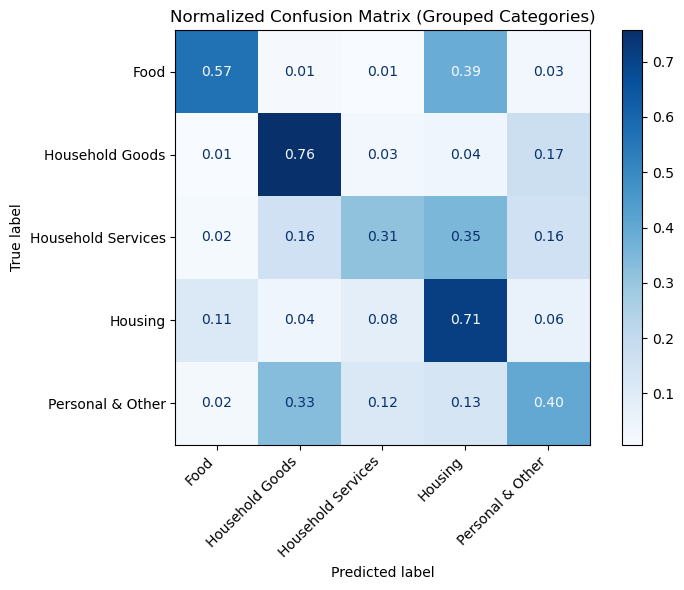

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# === Normalized Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred, labels=rf.classes_)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_norm, display_labels=rf.classes_)
disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.xticks(rotation=45, ha='right')
plt.title("Normalized Confusion Matrix (Grouped Categories)")
plt.tight_layout()
plt.show()


**Conclusion**:
    
    Housing and Household Goods are accurately predicted

    These categories have clearer demographic patterns (income + region)
    
    Household Services and Personal & Other remain hard to predict — likely due to:

    --Inconsistent regional patterns

    --Smaller support in training data



In [12]:
from sklearn.metrics import accuracy_score, f1_score

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Display results
print("✅ Model Performance Summary")
print(f"Accuracy: {accuracy:.3f}")
print(f"Macro F1 Score: {macro_f1:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")

✅ Model Performance Summary
Accuracy: 0.633
Macro F1 Score: 0.547
Weighted F1 Score: 0.633


### Feature Importance Insights

In [20]:
# === Feature Importance ===
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(["GEO", "Age of older adult"])) + ["Income"]
importances = rf.feature_importances_

grouped_importance = {
    "GEO": sum(imp for name, imp in zip(feature_names, importances) if "GEO" in name),
    "Age of older adult": sum(imp for name, imp in zip(feature_names, importances) if "Age of older adult" in name),
    "Income": importances[-1]
}
print("Feature importance:")
print(grouped_importance)

Feature importance:
{'GEO': 0.06619871751330783, 'Age of older adult': 0.03991877010746074, 'Income': 0.8938825123792313}


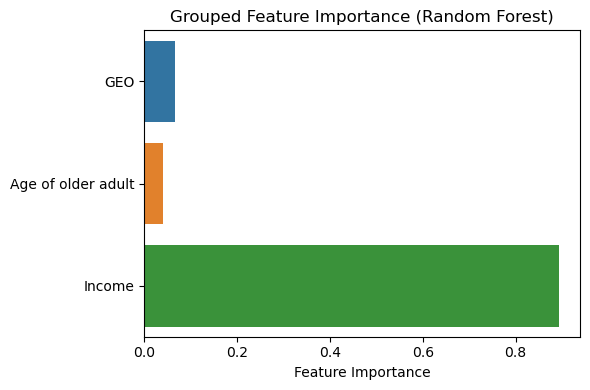

In [21]:

plt.figure(figsize=(6, 4))
sns.barplot(x=list(grouped_importance.values()), y=list(grouped_importance.keys()))
plt.xlabel("Feature Importance")
plt.title("Grouped Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

**Conclusion**:
The model’s decisions are driven primarily by economic capacity (income), with minor tuning from location (GEO) and very little from age.

1. Income Dominates

    Income is by far the most important feature — nearly 90% of the total split importance.

    This confirms what other plots showed:

        Income level strongly determines whether a household's dominant expense is Housing, Food, or discretionary categories like Goods or Services.

2. GEO Adds Some Value

    Region plays a modest role (~7%), likely reflecting:

        Housing market variation (urban vs. rural, cost of living)

        Regional infrastructure (e.g., reliance on fuel/electricity vs. services)


3. Age Group is Minimal

    Age explains only ~4% of decisions.

    This suggests:

        Age alone is not sufficient to predict what people spend most on.

        It may interact with income or region (e.g., older people may live in low-cost regions), but isn’t predictive on its own.

### Spending Behavior by Income

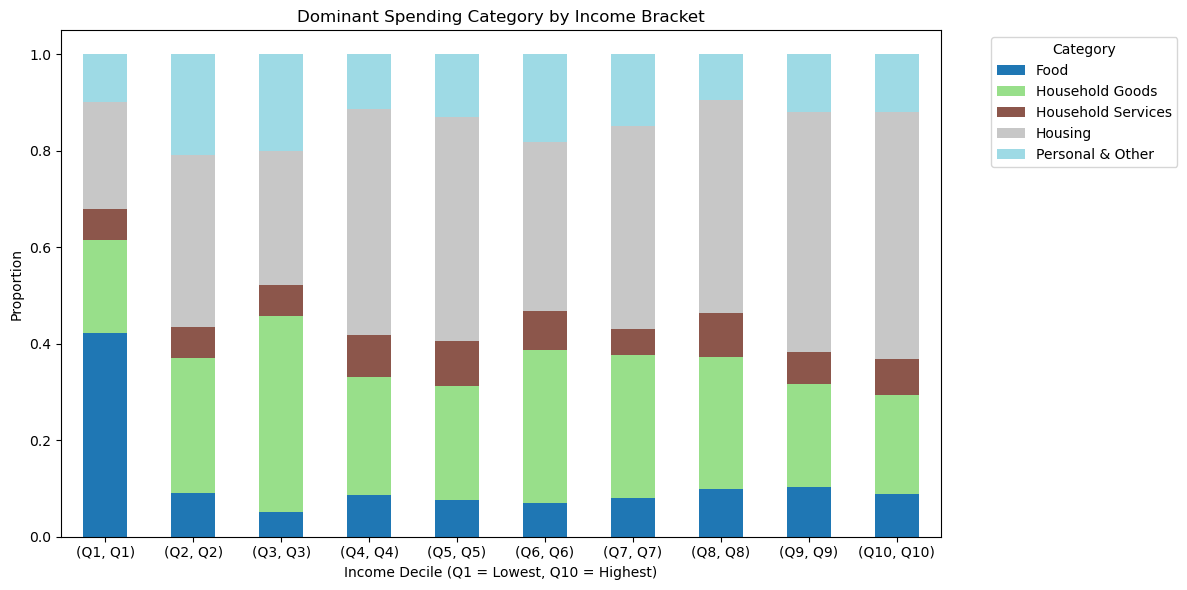

In [9]:
# === Dominant Category Distribution by Income Bracket ===
viz_df = dominant_expense_df.copy()
viz_df["Income_bin"] = pd.qcut(viz_df["Income"], q=10, labels=[f"Q{i+1}" for i in range(10)])

category_distribution = (
    viz_df.groupby(["Income_bin", "Dominant_Category"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

category_distribution.plot(
    kind='bar', stacked=True, colormap='tab20', figsize=(12, 6)
)
plt.ylabel("Proportion")
plt.xlabel("Income Decile (Q1 = Lowest, Q10 = Highest)")
plt.title("Dominant Spending Category by Income Bracket")
plt.xticks(rotation=0)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Conclusion**:

Food dominates in the lowest income decile (Q1)

Housing becomes more dominant at higher income levels (Q10)

Discretionary categories (e.g., Services, Personal & Other) remain minority choices across all deciles

Suggests income alone doesn’t fully explain spending priorities

### Class Distribution

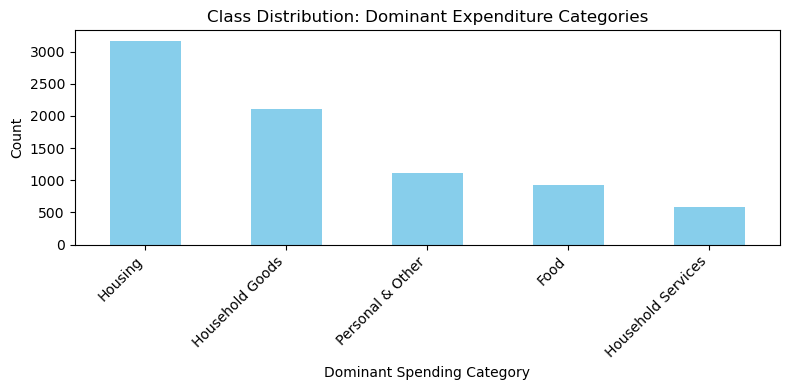

In [11]:
# Plot distribution of dominant categories (target variable)
plt.figure(figsize=(8, 4))
y.value_counts().plot(kind='bar', color='skyblue')
plt.ylabel("Count")
plt.xlabel("Dominant Spending Category")
plt.title("Class Distribution: Dominant Expenditure Categories")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Conclusion**:

1. Housing Dominates

    Most households across all demographics spend the largest share on housing.

    This reflects reality: housing is typically the single largest fixed cost.

2. Household Goods Are Next

    This includes furnishings, equipment, appliances — showing that mid-to-upper income groups shift toward durable goods once basic housing is met.

3. Food is Important but Not #1 for Many

    While essential, fewer groups have food as their top expense, likely because it’s less variable across income groups compared to housing.

4. “Household Services” and “Personal & Other” Are Niche

    These categories are less frequently the dominant type, likely because:

        They’re more discretionary

        Their expenses are smaller or more sporadic

5. Modeling Impact

    This imbalance explains:

        Why Housing and Household Goods are predicted well — more training data

        Why Services and Other had lower F1 scores — fewer examples to learn from